In [1]:
import pandas as pd
from pathlib import Path
import numpy as np

## Putting the features together

You can change `embs_df` to experiment with different representations. The best results are obtained with embeddings that are the mean of all tokens in the document.

In [2]:
data_dir = Path('../results')
style_csv = 'style_feats_train.csv'
embs_csv = 'embs_all_train.csv'

In [3]:
train_df = pd.read_csv(data_dir / style_csv, index_col=0)
embs_df = pd.read_csv(data_dir /embs_csv, index_col=0)

In [4]:
train_df = pd.concat([train_df, embs_df], axis=1, ignore_index=False)
train_df.head()

,hs,stereotype,raw_text,num_tokens,num_sentences,avg_sent_length,avg_word_length,uppercase_words_dist,num_mentions,num_hashtags,...,118,119,120,121,122,123,124,125,126,127
2066,0,0,"È terrorismo anche questo, per mettere in uno ...",20,1,20.0,5.166667,0.0,0,0,...,-0.092315,-0.006482,0.004965,-0.015565,0.001102,0.108430,0.055107,0.012827,0.033794,0.015369
2045,0,0,@user @user infatti finché ci hanno guadagnato...,15,1,15.0,4.733333,0.0,2,3,...,-0.102982,-0.009680,0.031605,-0.014103,0.004536,0.047874,0.057404,-0.010024,0.025529,0.026676
61,0,0,"Corriere: Tangenti, Mafia Capitale dimenticata...",13,1,13.0,6.181818,0.0,0,1,...,-0.110790,-0.035368,0.018365,-0.022573,-0.000332,-0.012821,0.043854,-0.015398,-0.039438,0.101354
1259,0,0,"@user ad uno ad uno, perché quando i migranti ...",21,1,21.0,4.789474,0.0,1,0,...,-0.082383,0.002918,0.006570,-0.020704,-0.025993,0.093011,0.072015,0.025828,0.012830,0.074992
949,0,0,Il divertimento del giorno? Trovare i patrioti...,24,2,12.0,5.650000,0.0,0,1,...,-0.040242,-0.030930,-0.018728,-0.040692,-0.011330,0.034857,0.020099,-0.004775,0.001370,0.084870


## Model

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

In [6]:
train_X = train_df.drop(['hs', 'stereotype', 'raw_text'], axis=1)
train_y = train_df['hs']

In [7]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LinearSVC())
    ], verbose=True)

pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', LinearSVC())], verbose=True)

In [8]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [9]:
splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'f1_positive': make_scorer(f1_score, pos_label=1, zero_division=0)
}

In [10]:
scores = cross_validate(pipeline, train_X, train_y, scoring=scoring, cv=splitter)
print("Mean macro-f1:", np.mean(scores['test_f1_macro']).round(3))
print("Standard deviation macro-f1:", np.std(scores['test_f1_macro']).round(3))

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.4s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
Mean macro-f1: 0.757
Standard deviation macro-f1: 0.011


In [11]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
baselines_scores = cross_validate(dummy_clf, train_X, train_y, scoring=scoring)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
scores_df = pd.DataFrame(scores)
scores_df['model'] = 'actual model'
scores_df['iteration'] = list(range(1, 6))
baselines_scores_df = pd.DataFrame(baselines_scores)
baselines_scores_df['model'] = 'dummy classifier'
baselines_scores_df['iteration'] = list(range(1, 6))

scores_df = pd.concat([scores_df, baselines_scores_df]).drop(['fit_time', 'score_time'], axis=1)
scores_df_long = pd.melt(scores_df, id_vars=['model', 'iteration'], var_name='metric')

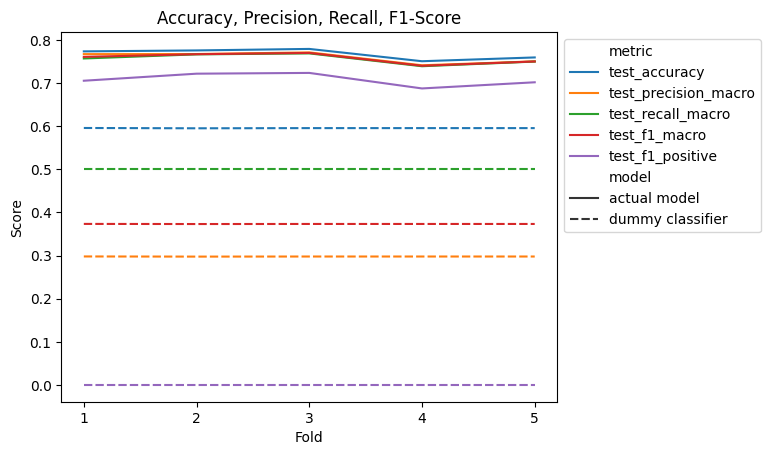

In [14]:
sns.lineplot(scores_df_long, x='iteration', y='value', hue='metric', style='model')
plt.xticks(list(range(1, 6)))
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Accuracy, Precision, Recall, F1-Score")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.3s


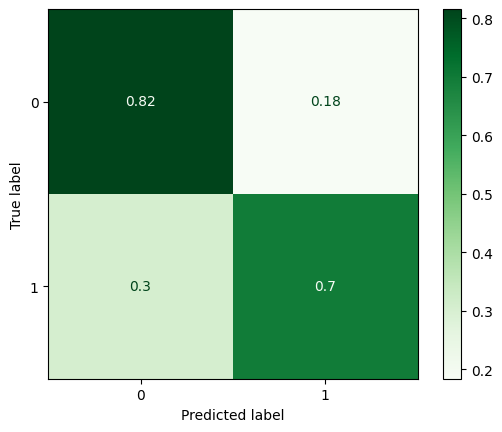

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = cross_val_predict(pipeline, train_X, train_y, cv=splitter)
ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=train_y, cmap='Greens', normalize='true')
plt.show()

In [16]:
pipeline.fit(train_X, train_y)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.5s


Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', LinearSVC())], verbose=True)

## Feature importance

In [17]:
coefs = pipeline['clf'].coef_[0]
feat_names = pipeline[:-1].get_feature_names_out()

feat_importance = pd.DataFrame(coefs, columns=("coef",), index=feat_names)
feat_importance.sort_values('coef', ascending=False).head(10)

,coef
num_sentences,1.680906
60,1.636779
86,1.200830
62,1.006538
18,1.000612
32,0.987013
33,0.877252
35,0.830734
22,0.680499
40,0.675926


In [18]:
feat_importance.sort_values('coef', ascending=True).head(10)

,coef
deprel_dist_root,-1.688604
26,-1.164408
34,-0.948557
96,-0.936395
upos_dist_PUNCT,-0.894250
73,-0.863158
deprel_dist_flat,-0.856506
16,-0.845457
upos_dist_ADP,-0.831870
upos_dist_CCONJ,-0.823573
